In [1]:
from simulation_enviroment import DemandResponseEviroment
from policies import *
from noise_functions import gaussian_stochastic,identity
from pricing_generators import *
from reward_functions import *
import sys
import seaborn as sns

In [2]:
%matplotlib inline
length = 1440
sys.setrecursionlimit(length * 10)

In [3]:
def reward_function(s, cells):
    #return boundary_exceedence_cost(s, cells)
    return energy_price_cost(s, cells) + switch_cost(s, cells) + boundary_exceedence_cost(s, cells)

In [4]:
gamma = -1 * (1/length - 1)
gamma = 0.9
print(gamma)

0.9


In [5]:
env =  DemandResponseEviroment(episode_length=length * 2,  noise_function=gaussian_stochastic, 
                               pricing_generator=ApxShiftPricingGenerator)

In [6]:
p = QLearningGBPolicy(alpha=0.4, gamma=gamma, epsilon=0.99, length = length)

# Q-function computation

In [7]:
rewards = []
def play(p, t, update = True):
    if t > length * 2 + 1:
        return 0
    s , cells = env.get_global_state(), env.cells
    action = p.policy(s, cells)
    env.execute_action(action)
    ns , ncells = env.get_global_state(), env.cells
    reward = reward_function(ns, ncells) + gamma  * play(p, t + 1, update)
    if t < length:
        if update:
            p.update(s, cells, action, ns, ncells, reward)
        rewards.append(reward)
    return reward

# Training

In [8]:
iters = 100
avg_rewards = []
for i in range(iters):
    env.start_episode(visualise=False)
    play(p, 0)
    r = sum(rewards)/len(rewards)
    if not i % 10:
        print('Starting iter..', i, r, p.epsilon)
    avg_rewards.append(r)
    rewards = []
    


Starting iter.. 0 -0.0567672538527 0.9611800000001312
Starting iter.. 10 -0.041895141541 0.6729800000014428
Starting iter.. 20 -0.0317625325575 0.38478000000211476
Starting iter.. 30 -0.0143245764493 0.09658000000186598
Starting iter.. 40 -0.00729198295013 -0.19161999999818013
Starting iter.. 50 -0.0042849815901 -0.47981999999846836
Starting iter.. 60 -0.00351009795896 -0.7680199999972688
Starting iter.. 70 -0.00297594082532 -1.0562199999965813
Starting iter.. 80 -0.00266903259551 -1.3444199999984694
Starting iter.. 90 -0.00354471604376 -1.6326200000003575


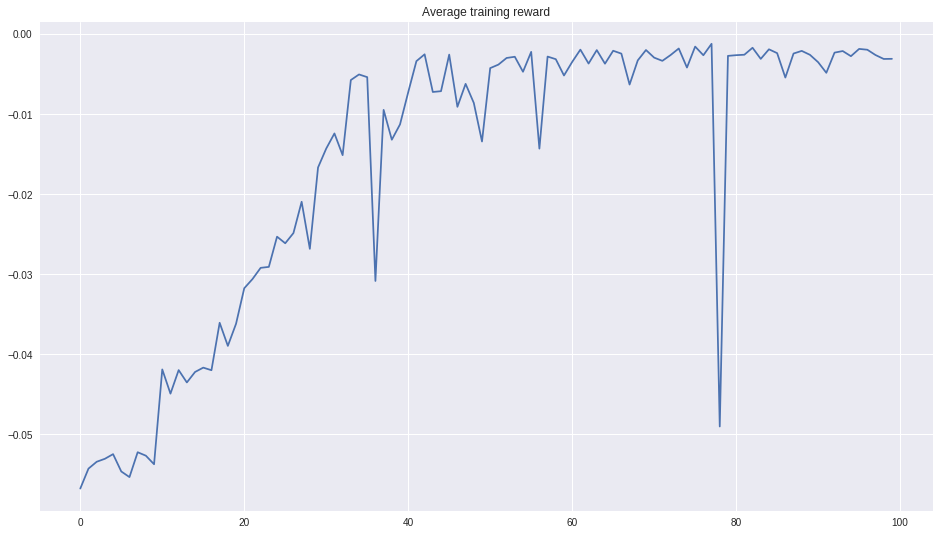

In [9]:
f = plt.figure()
f.set_size_inches(16, 9)
_ = plt.plot(avg_rewards)
plt.title('Average training reward')

# Benchmark policy

VISUALISING
realised_price: 97.06391347099276


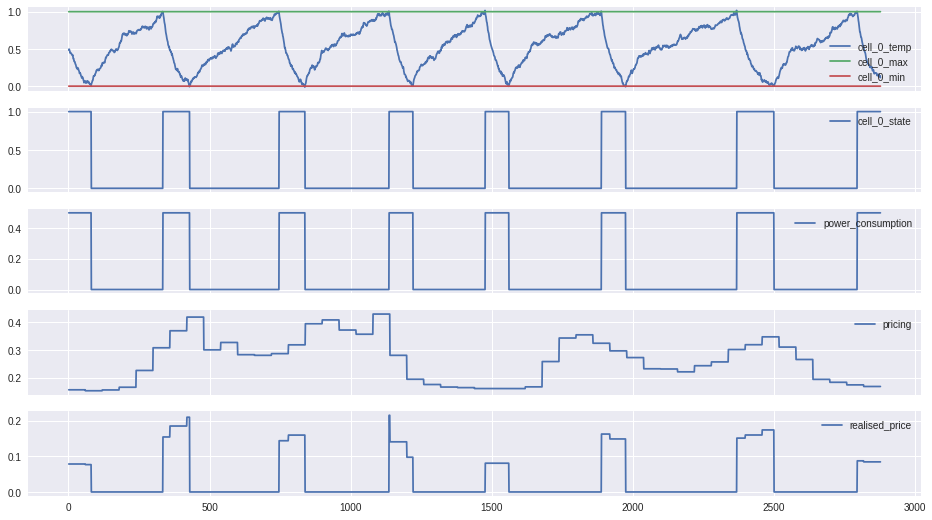

-0.00432062640992


In [10]:
qp = LatestSwitchPolicy(reward_function)
rewards = []
env.start_episode(visualise=True)
play(qp, 0, update=False)
print(sum(rewards)/len(rewards))

# RL policy

VISUALISING
realised_price: 48.400045382346356


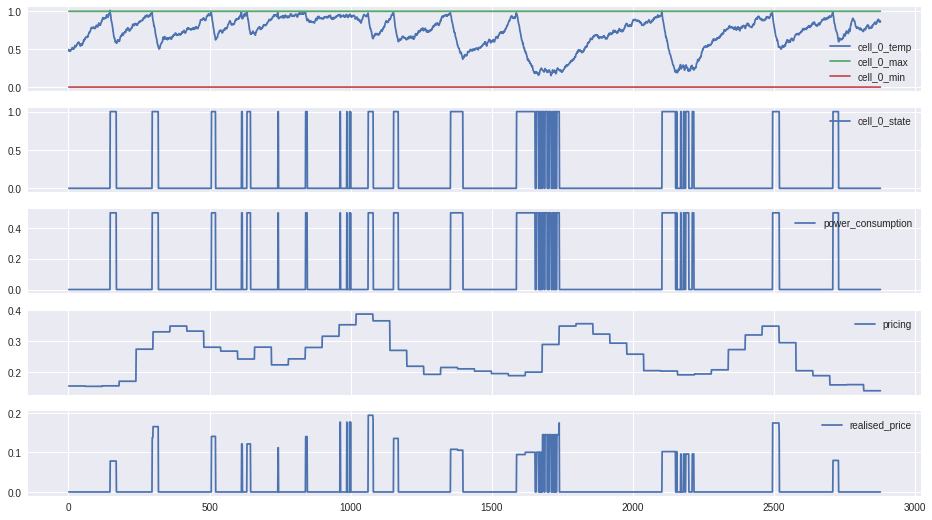

-0.00353636276134
-1.9208200000022455


In [11]:

rewards = []
env.start_episode(visualise=True)
play(p, 0, update=False)
#print(price)
print(sum(rewards)/len(rewards))
print(p.epsilon)

# Compare RL vs. Benchmark

In [12]:
basic_rewards = []
basic_monays = []
for _ in range(100):    
    rewards = []
    env.start_episode(visualise=False)
    play(qp, 0, update=False)
    history = env.episode_history
    history_dataframe =  pd.DataFrame(history).T
    realised_price  = history_dataframe['pricing'] * history_dataframe['power_usage']
    basic_monays.append(realised_price.sum())
    basic_rewards.append(sum(rewards)/len(rewards))
    
    
rl_rewards = []
rl_monays = []
for _ in range(100):    
    rewards = []
    env.start_episode()
    play(p, 0, update=False)
    rl_rewards.append(sum(rewards)/len(rewards))
    history = env.episode_history
    history_dataframe =  pd.DataFrame(history).T
    realised_price  = history_dataframe['pricing'] * history_dataframe['power_usage']
    rl_monays.append(realised_price.sum())

/home/lucas/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


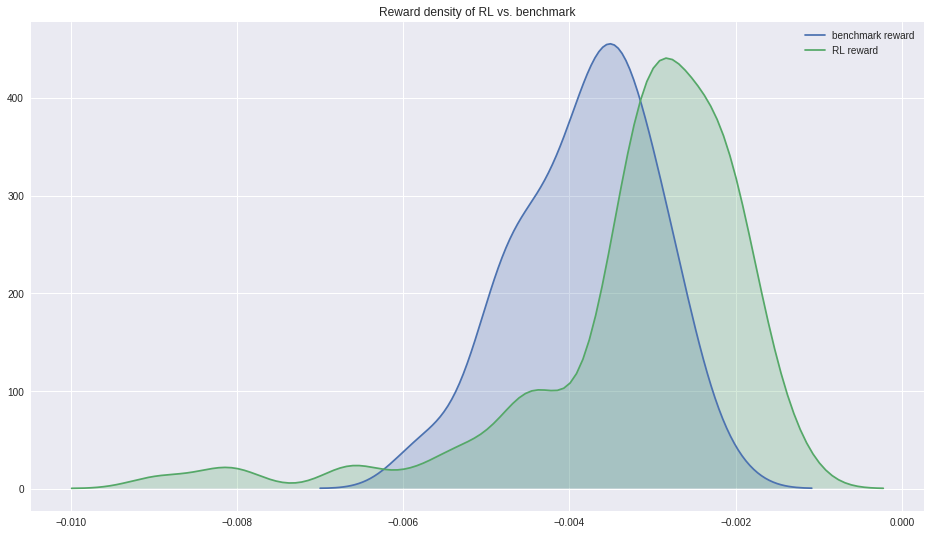

In [13]:
f = plt.figure()
f.set_size_inches(16, 9)
sns.kdeplot(np.array(basic_rewards), shade=True, label = 'benchmark reward')
sns.kdeplot(np.array(rl_rewards), shade=True, label = 'RL reward')
plt.title('Reward density of RL vs. benchmark')

/home/lucas/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


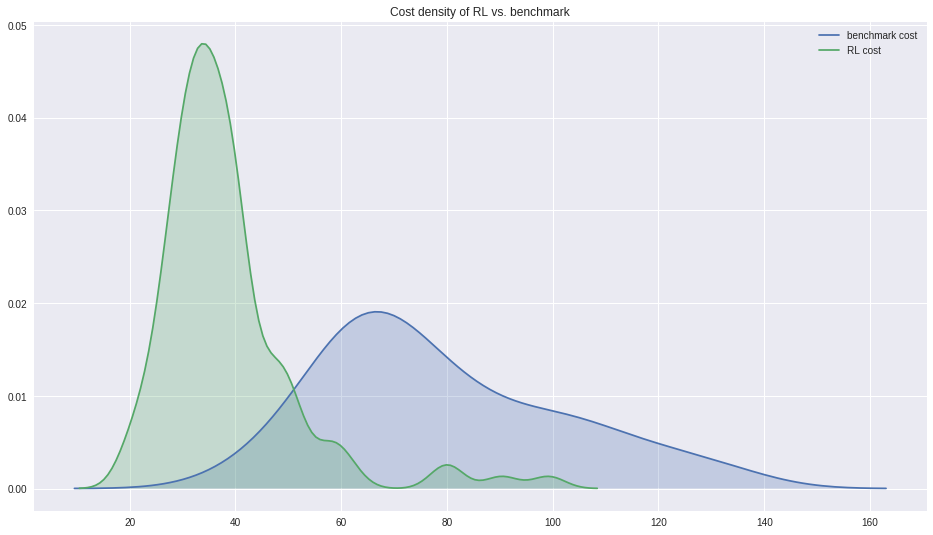

In [14]:
f = plt.figure()
f.set_size_inches(16, 9)
sns.kdeplot(np.array(basic_monays), shade=True, label = 'benchmark cost')
sns.kdeplot(np.array(rl_monays), shade=True , label = 'RL cost')
plt.title('Cost density of RL vs. benchmark')

# When does RL > Benchmark?

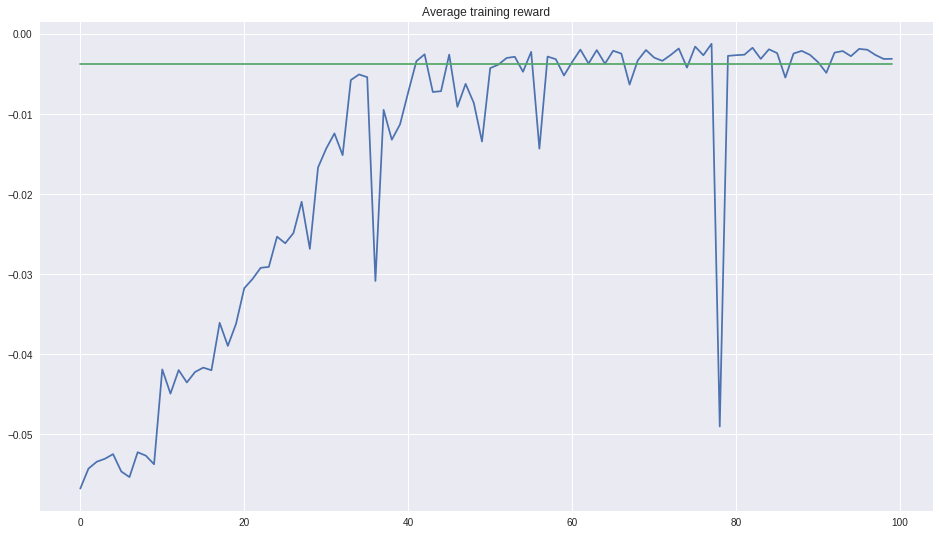

In [18]:
f = plt.figure()
f.set_size_inches(16, 9)
_ = plt.plot(avg_rewards)
_ = plt.plot([np.mean(basic_rewards)] * len(avg_rewards))
plt.title('Average training reward')